In [11]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score, 
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_curve,
                             auc)

from sklearn.neural_network import MLPClassifier

# Preprocessing

## Missing values

In [12]:
# Import adult data, 
data = pd.read_csv("/Users/ruthwalters/Library/CloudStorage/Dropbox/FALL 2025/Machine learning/Projects/proj2/data/project_adult.csv", 
                   index_col=0, 
                   na_values="?") # Assign any instances of "?" to NA
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5514,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
19777,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
10781,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
32240,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,<=50K
9876,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [13]:
# Determine which columns have NA values
print(data.isna().sum())

age                  0
workclass         1447
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1454
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     458
income               0
dtype: int64


In [14]:
# Determine how significantly removing NA values would impact the dataset
print(f"Remaining data: {len(data.dropna()) / len(data) * 100:.2f}%")

Remaining data: 92.74%


In [15]:
# Impute NA values with the mode
for col in ['workclass', 'occupation', 'native-country']:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [16]:
# Recheck for missing values
print(data.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


# Modeling

In [17]:
# Split the dataset into features (X) and target (y) 
X = data.drop('income', axis=1)
y = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,      # 30-70 training-testing split
                                                    random_state=41103, # Random state for reproducibility
                                                    stratify=y)         # Stratify to ensure equal distribution of response classes



In [18]:
# Define categorical columns for training data
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country']

numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain',
             'capital-loss', 'hours-per-week']

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
    ]
)

## Baseline model

In [20]:
# Use default parameters for the baseline MLP
mlp_baseline = MLPClassifier(random_state=41103, max_iter=1000)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', mlp_baseline)
])

pipe.fit(X_train, y_train)

y_pred_baseline = pipe.predict(X_test)
y_prob_baseline = pipe.predict_proba(X_test)[:, 1]

In [21]:
print("Test Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Precision:", precision_score(y_test, y_pred_baseline))
print("Recall:", recall_score(y_test, y_pred_baseline))
print("F1 Score:", f1_score(y_test, y_pred_baseline))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_baseline))
print("\nClassification Report:\n", classification_report(y_test, y_pred_baseline))

Test Accuracy: 0.8316058861164427
Precision: 0.6546250684181719
Recall: 0.6358320042530569
F1 Score: 0.645091693635383
ROC-AUC: 0.764747818776343

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      5934
           1       0.65      0.64      0.65      1881

    accuracy                           0.83      7815
   macro avg       0.77      0.76      0.77      7815
weighted avg       0.83      0.83      0.83      7815



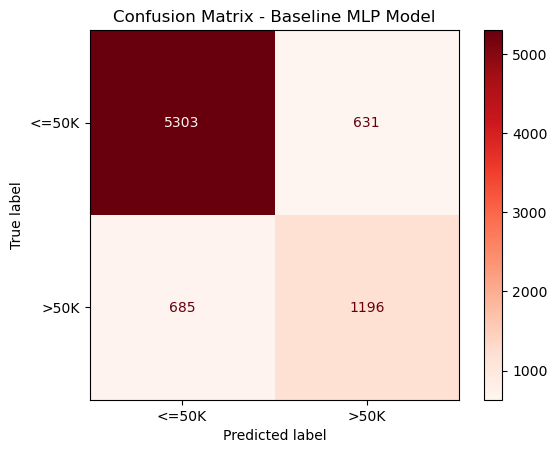

In [22]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Reds', values_format='d')
plt.title('Confusion Matrix - Baseline MLP Model')
plt.show()

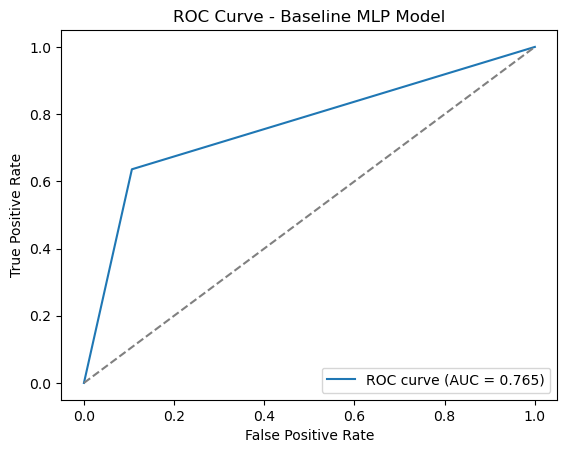

ROC-AUC Score: 0.7647


In [23]:
# Generate an ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_baseline)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline MLP Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_baseline):.4f}")

## Model refinement

### Model development
Running `GridSearchCV` yields some important insight into the optimal model:
- While 'lbfgs' is a commonly used solver, it preforms poorly  for this dataset, and often fails to converge even with a high `max_iter`. This makes sense given that the dataset contains several one-hot-encoded categorical features (and therefore a high-dimensional feature space). 'sgd', which is better at handling this kind of data, was able to achieve much higher convergence rates
- Using a high learning rate often results in failure to converge, so we should keep learning rate at or below 0.01
- Higher regularization values seem to converege more often


This dataset generally seems to favor stochastic solvers, small learning rates, and stronger regularization for reliable convergence. This is consistent with what we understand about the dataset’s sparse, imbalanced, and mixed-type features. 

### Final version

In [24]:
# Define MLP model
mlp = MLPClassifier(max_iter=1000, random_state=41103)

# Construct parameters for GridSearch to search over
param_grid = {
    # Try a small hidden layer, a larger hidden layer, and two hidden layers
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    
    # Try relu and tanh activatiion layers
    'mlp__activation': ['relu', 'tanh'],
    
    # Try Adam and Stochastic Gradient Descent solvers; both good for converging on larger datasets
    'mlp__solver': ['adam', 'sgd'],

    # Try small, midline, and large regularization values
    'mlp__alpha': [0.0001, 0.001, 0.01],

    # Try a conservative learning rate and an aggressive learning rate
    'mlp__learning_rate_init': [0.001, 0.01]
}

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('mlp', mlp)])

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=   5.3s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=   6.5s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=   6.7s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   7.0s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   9.2s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   7.2s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, 

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time= 1.8min


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time= 1.8min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  24.3s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  39.0s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  10.9s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  32.8s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  12.9s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, ml

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time= 1.8min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  10.6s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  10.7s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   7.3s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  11.0s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=  30.9s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time= 2.0min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  25.5s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  11.6s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=  29.8s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  11.4s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=  34.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time= 2.0min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  12.8s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=  31.9s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=  26.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=  26.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=  28.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time= 2.0min
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  11.6s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  11.0s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  54.1s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  54.0s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  52.8s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  29.9s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  29.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  29.9s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.4min
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.5min


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.6min
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  24.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  39.9s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  23.8s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.6min


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.5min
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  17.6s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  17.1s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.6min
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  24.3s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.6min
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.7min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=   8.9s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=   8.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_i

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.1min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  48.7s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  53.7s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  54.5s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 2.0min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  11.3s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  12.0s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 2.3min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  11.7s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.1min


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  17.8s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 2.3min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  21.7s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  24.1s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.7min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  23.8s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.5min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  22.4s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  39.0s


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.5min


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.6min


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.6min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  18.9s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  16.4s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.6min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  17.3s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.8min
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(50,), mlp__learning_rat

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time=  53.1s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  10.7s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  11.8s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  11.0s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   9.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 2.0min
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__s

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 2.3min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 2.3min
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.1min
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  28.7s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  33.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=sgd; total time=  23.1s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.6min


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.6min
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=  15.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001, mlp__solver=adam; total time= 1.5min


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.6min
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.4min
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.4min


/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/model_selection/_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01, mlp__solver=sgd; total time= 1.4min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'education-num',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('mlp',
                                        MLPClassifier(max_iter=1000,
                                                      random_state=41103))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['relu', 'tanh'],
                         'mlp__alpha': [0.0001, 0.001, 0.01],
                         'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
                         'mlp__learning_rate_init': [0.001, 0.01],
                         'mlp__solver': ['adam', 'sgd']},
             scoring='accuracy', verbose=2)

In [25]:
print("Best parameters:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

Best parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'sgd'}
Best cross-val accuracy: 0.8530684034074141


In [26]:
# Get the best model from GridSearch
best_model = grid.best_estimator_

# Get the best model's predictions 
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Test Accuracy: 0.8541266794625719
Precision: 0.7235968617984309
Recall: 0.6374269005847953
F1 Score: 0.677784058790277
ROC-AUC: 0.7801222807608843

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      5934
           1       0.72      0.64      0.68      1881

    accuracy                           0.85      7815
   macro avg       0.81      0.78      0.79      7815
weighted avg       0.85      0.85      0.85      7815



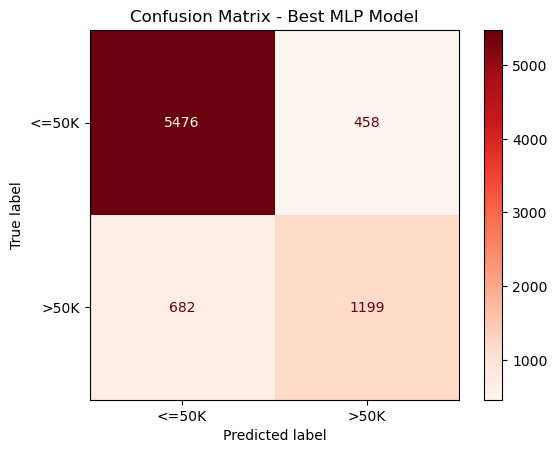

In [27]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Reds', values_format='d')
plt.title('Confusion Matrix - Best MLP Model')
plt.show()

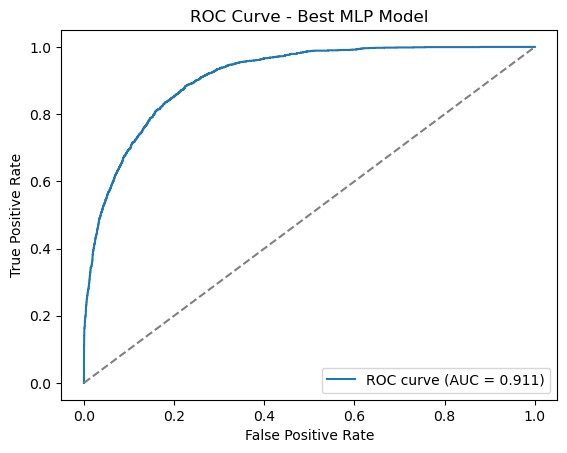

ROC-AUC Score: 0.9111


In [28]:
# Generate an ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best MLP Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_best):.4f}")


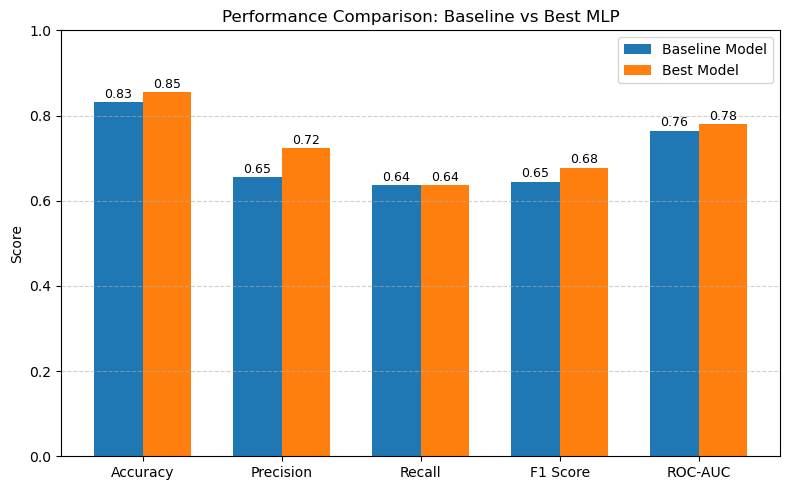

In [30]:
# Organize data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
baseline_scores = [accuracy_score(y_test, y_pred_baseline), 
               precision_score(y_test, y_pred_baseline), 
               recall_score(y_test, y_pred_baseline), 
               f1_score(y_test, y_pred_baseline), 
               roc_auc_score(y_test, y_pred_baseline)]
best_scores = [accuracy_score(y_test, y_pred_best), 
               precision_score(y_test, y_pred_best), 
               recall_score(y_test, y_pred_best), 
               f1_score(y_test, y_pred_best), 
               roc_auc_score(y_test, y_pred_best)]

x = np.arange(len(metrics))
width = 0.35

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_scores, width, label='Baseline Model')
plt.bar(x + width/2, best_scores, width, label='Best Model')

plt.ylabel('Score')
plt.title('Performance Comparison: Baseline vs Best MLP')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, v in enumerate(baseline_scores):
    plt.text(i - width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)
for i, v in enumerate(best_scores):
    plt.text(i + width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## Output

In [31]:
import numpy as np

# Load the validation dataset
validation_inputs = pd.read_csv("/Users/ruthwalters/Library/CloudStorage/Dropbox/FALL 2025/Machine learning/Projects/proj2/data/project_validation_inputs.csv", index_col=0, na_values="?")

# Use the same preprocessing
for col in ['workclass', 'occupation', 'native-country']:
    validation_inputs[col].fillna(data[col].mode()[0], inplace=True)

# Predict using the best trained MLP model
validation_preds = best_model.predict(validation_inputs)

# Convert to DataFrame for export
validation_df = pd.DataFrame(validation_preds, columns=['Predicted'])

# Save predictions to CSV using required naming convention
validation_df.to_csv('Group_29_MLP_PredictedOutputs.csv', index=False)